In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sc

%matplotlib inline

In [2]:
time_array = np.arange(0, 1000000, 1)
pi = 2906
B = 1.27 #RBBL/STB
mu = 0.1 #cP
k = 20 #mD
h = 30 #ft
phi = 0.28 #frac
ct = 3*10**-6 #psi^-1
r = 100 #ft
np.random.seed(120296)

data_nametag = "bigdata"
df_string = "tabular_" + data_nametag + ".xlsx"
flowrate_df = pd.read_excel(df_string, index_col=0)
t_list = flowrate_df["END(sec)"].values
q_list = flowrate_df["FLOWRATE"].values
t_list = np.insert(t_list, 0, 0)
q_list = np.insert(q_list, 0, 0)
q_list = np.insert(q_list, -1, q_list[-1])

In [3]:
def superposition(t_list, q_list, t_arange, initial_pressure, B, mu, k, h, phi, ct, r):
    pressure_list = []
    for t in t_arange:
        for idx, t_start in enumerate(t_list):
            if t_start >= t:
                #this is the next large t_mark, we need the index of this t_mark
                #so that we can iterate over the length of the index
                t_idx = idx
                break
            t_idx = len(t_list) #if t is greater than all ts in t_list,
            #then we want t_idx to cover all t_list
        pressure_drop = 0 #first set it equal to 0
        for i in range(t_idx):
            pressure_drop += (70.6 * (q_list[i+1]-q_list[i]) * B * mu / (k*h)) * -sc.expi(-(948*phi*mu*ct*r**2)/(k*(t - t_list[i]))) 
        pressure_list.append(initial_pressure-pressure_drop)
    return pressure_list


def outlier_generator(percentage_of_outliers, dataset):
    pressure_list_with_outliers = list(dataset)
    outlier_list = [50, 75, 100]
    outlier_sign = [-1, 1]
    num_of_outliers = int(len(dataset)*percentage_of_outliers/100)
    outlier_index = np.random.choice(len(dataset), size=num_of_outliers, replace=False)
    for idx in outlier_index:
        outlier = np.random.choice(outlier_list) * np.random.choice(outlier_sign)
        pressure_list_with_outliers[idx] += outlier
    return pressure_list_with_outliers

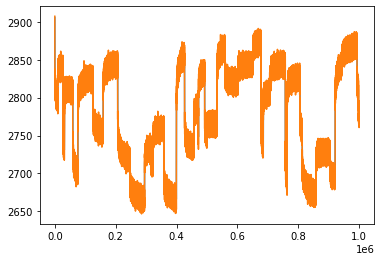

In [4]:
pdg_clean = superposition(t_list, q_list, time_array, pi, B, mu, k, h, phi, ct, r)
mu, sigma = 0, 5 # For noise generation
noise = np.random.normal(mu, sigma, len(pdg_clean))
pdg_noisy = pdg_clean + noise
pdg_outliers = outlier_generator(1, pdg_noisy)

In [5]:
tuples_clean = list(zip(time_array, pdg_clean))
tuples_noisy = list(zip(time_array, pdg_noisy))
tuples_outliers = list(zip(time_array, pdg_outliers))
clean_string = "clean_" + data_nametag + ".csv"
noisy_string = "noisy_" + data_nametag + ".csv"
outliers_string = "outliers_" + data_nametag + ".csv"
df_clean = pd.DataFrame(tuples_clean, columns=['Time(s)', 'Pressure(psi)'])
df_noisy = pd.DataFrame(tuples_noisy, columns=['Time(s)', 'Pressure(psi)'])
df_outliers = pd.DataFrame(tuples_outliers, columns=['Time(s)', 'Pressure(psi)'])
df_clean.to_csv(clean_string)
df_noisy.to_csv(noisy_string)
df_outliers.to_csv(outliers_string)